In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats
import random

import utilities as ut
import modularised_utils as mut

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

sns.set_theme(style="whitegrid")
seed = 42
np.random.seed(seed)

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [72]:
experiment = 'slc'
path = f"data/{experiment}/results"
saved_folds = joblib.load(f"data/{experiment}/cv_folds.pkl")


In [73]:
# Load the dictionaries containing the results for each optimization method
diroca_results = joblib.load(f"{path}/diroca_cv_results.pkl")
gradca_results = joblib.load(f"{path}/gradca_cv_results.pkl")
baryca_results = joblib.load(f"{path}/baryca_cv_results.pkl")

print("Successfully loaded results for all optimization methods.")
print(f"  - DIROCA results keys: {list(diroca_results.keys())}")
print(f"  - GradCA results keys: {list(gradca_results.keys())}")
print(f"  - BARYCA results keys: {list(baryca_results.keys())}")

results_to_evaluate = {}

# --- Add the baseline methods first ---
results_to_evaluate['GradCA'] = gradca_results
results_to_evaluate['BARYCA'] = baryca_results
# results_to_evaluate['Abs-LiNGAM'] = abslingam_results

# --- Unpack each DIROCA hyperparameter run into its own "method" ---
# First, find all the different DIROCA runs you tested (e.g., 'eps_delta_2', 'eps_delta_4')
# We can find them by looking at the keys in the first fold's results.
if diroca_results:
    first_fold_key = list(diroca_results.keys())[0]
    diroca_run_ids = list(diroca_results[first_fold_key].keys())

    # Now, create a separate entry for each DIROCA run
    for run_id in diroca_run_ids:
        # Create a new, descriptive name for this method, e.g., "DIROCA (eps_delta_8)"
        method_name = f"DIROCA ({run_id})"
        
        # Create a new dictionary that will only contain the results for this specific run_id
        new_diroca_dict = {}
        for fold_key, fold_results in diroca_results.items():
            # For each fold, just grab the data for the current run_id
            if run_id in fold_results:
                new_diroca_dict[fold_key] = {run_id: fold_results[run_id]}
        
        # Add this new, filtered dictionary to our main evaluation dictionary
        results_to_evaluate[method_name] = new_diroca_dict

print("\nMethods available for evaluation:")
for key in results_to_evaluate.keys():
    print(f"  - {key}")

Successfully loaded results for all optimization methods.
  - DIROCA results keys: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4']
  - GradCA results keys: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4']
  - BARYCA results keys: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4']

Methods available for evaluation:
  - GradCA
  - BARYCA
  - DIROCA (eps_delta_4)
  - DIROCA (eps_delta_8)
  - DIROCA (eps_delta_1)
  - DIROCA (eps_delta_2)
  - DIROCA (eps_delta_0.111)


In [74]:
label_map_gaussian = {
                        'DIROCA (eps_delta_0.111)': 'DiRoCA_star',
                        'DIROCA (eps_delta_1)': 'DIROCA_1',
                        'DIROCA (eps_delta_2)': 'DIROCA_2',
                        'DIROCA (eps_delta_4)': 'DIROCA_4',
                        'DIROCA (eps_delta_8)': 'DIROCA_8',
                        'GradCA': 'GradCA',
                        'BARYCA': 'BARYCA'
                    }
results_to_evaluate = {label_map_gaussian.get(key, key): value for key, value in results_to_evaluate.items()}


In [75]:
# Load the original data dictionary
all_data      = ut.load_all_data(experiment)

Dll_samples   = all_data['LLmodel']['data']
Dhl_samples   = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega         = all_data['abstraction_data']['omega']
ll_var_names  = list(all_data['LLmodel']['graph'].nodes())
hl_var_names  = list(all_data['HLmodel']['graph'].nodes())

Data loaded for 'slc'.


In [76]:
def calculate_abstraction_error(T_matrix, Dll_test, Dhl_test):
    """
    Calculates the abstraction error for a given T matrix on a test set.

    This function works in the space of distribution parameters:
    1. It estimates Gaussian parameters (mean, cov) from the LL and HL test samples.
    2. It transforms the LL Gaussian's parameters using the T matrix.
    3. It computes the Wasserstein distance between the transformed LL distribution
       and the actual HL distribution.
    
    Args:
        T_matrix (np.ndarray): The learned abstraction matrix.
        Dll_test (np.ndarray): The low-level endogenous test samples.
        Dhl_test (np.ndarray): The high-level endogenous test samples.
        
    Returns:
        float: The calculated Wasserstein-2 distance.
    """
    # 1. Estimate parameters from the low-level test data
    mu_L_test    = np.mean(Dll_test, axis=0)
    Sigma_L_test = np.cov(Dll_test, rowvar=False)

    # 2. Estimate parameters from the high-level test data
    mu_H_test    = np.mean(Dhl_test, axis=0)
    Sigma_H_test = np.cov(Dhl_test, rowvar=False)

    # 3. Transform the low-level parameters using the T matrix
    # This projects the low-level distribution into the high-level space
    mu_V_predicted    = mu_L_test @ T_matrix.T
    Sigma_V_predicted = T_matrix @ Sigma_L_test @ T_matrix.T
    
    # 4. Compute the Wasserstein distance between the two resulting Gaussians
    try:
        wasserstein_dist = np.sqrt(mut.compute_wasserstein(mu_V_predicted, Sigma_V_predicted, mu_H_test, Sigma_H_test))
    except Exception as e:
        print(f"  - Warning: Could not compute Wasserstein distance. Error: {e}. Returning NaN.")
        return np.nan

    return wasserstein_dist

## F-contamination

In [77]:
def contaminate_data(data, strength, contamination_type, num_segments=10, seed=None):
    """
    Applies a specified contamination to data samples to simulate model misspecification.

    Args:
        data (np.ndarray): The original data samples.
        strength (float): The magnitude of the contamination.
        contamination_type (str): 'piecewise', 'multiplicative', or 'nonlinear'.
        num_segments (int): Number of segments for the 'piecewise' type.
        seed (int, optional): Random seed for reproducibility.
        
    Returns:
        np.ndarray: The contaminated data.
    """
    rng = np.random.default_rng(seed)
    data_cont = data.copy()
    
    if contamination_type == "multiplicative":
        # Apply element-wise multiplicative noise
        noise = rng.uniform(low=1.0 - strength, high=1.0 + strength, size=data.shape)
        data_cont *= noise
  
    elif contamination_type == "nonlinear":
        # Apply a sine-based non-linear distortion
        data_cont += strength * np.sin(data_cont)
  
    elif contamination_type == "piecewise":
        # Apply piecewise contamination to each column (variable)
        for col_idx in range(data.shape[1]):
            column = data_cont[:, col_idx]
            breakpoints = np.quantile(column, q=np.linspace(0, 1, num_segments + 1))
            breakpoints[-1] += 1e-6 # Ensure the last element is included
            
            for i in range(num_segments):
                factor = 1.0 + rng.uniform(low=-strength, high=strength)
                mask = (column >= breakpoints[i]) & (column < breakpoints[i+1])
                data_cont[mask, col_idx] *= factor
  
    else:
        raise ValueError(f"Unknown contamination type: {contamination_type}")
  
    return data_cont

In [78]:
# Choose which type of non-linearity to test
contamination_type_to_run = 'multiplicative' # Options: 'piecewise', 'multiplicative', 'nonlinear'

# Define the range of contamination strengths to test
contamination_strengths = np.linspace(0, 1, 10) 

# Number of random contaminations to average over for each setting
num_trials = 10

f_spec_records = []
print(f"F '{contamination_type_to_run}' misspecification evaluation")

for strength in tqdm(contamination_strengths, desc="Contamination Strength"):
    for trial in range(num_trials):
        for i, fold_info in enumerate(saved_folds):
            for method_name, results_dict in results_to_evaluate.items():
                fold_results = results_dict.get(f'fold_{i}', {})
                for run_key, run_data in fold_results.items():

                    if 'DIROCA' in method_name:
                        method_label = method_name
                    else:
                        method_label = method_name

                    T_learned = run_data['T_matrix']
                    test_indices = run_data['test_indices']
                    
                    errors_per_intervention = []
                    for iota in I_ll_relevant:
                        Dll_test_clean = Dll_samples[iota][test_indices]
                        Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
                        
                        Dll_test_cont = contaminate_data(Dll_test_clean, strength, contamination_type_to_run, seed=trial)
                        Dhl_test_cont = contaminate_data(Dhl_test_clean, strength, contamination_type_to_run, seed=trial)
                        
                        error = calculate_abstraction_error(T_learned, Dll_test_cont, Dhl_test_cont)
                        if not np.isnan(error):
                            errors_per_intervention.append(error)
                    
                    avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                    
                    record = {
                        'method': method_label, 
                        'contamination': strength,
                        'trial': trial,
                        'fold': i,
                        'error': avg_error
                    }
                    f_spec_records.append(record)

f_spec_df = pd.DataFrame(f_spec_records)
print("--- F-Misspecification Evaluation Complete ---")

F 'multiplicative' misspecification evaluation


Contamination Strength:   0%|          | 0/10 [00:00<?, ?it/s]

Contamination Strength: 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]

--- F-Misspecification Evaluation Complete ---


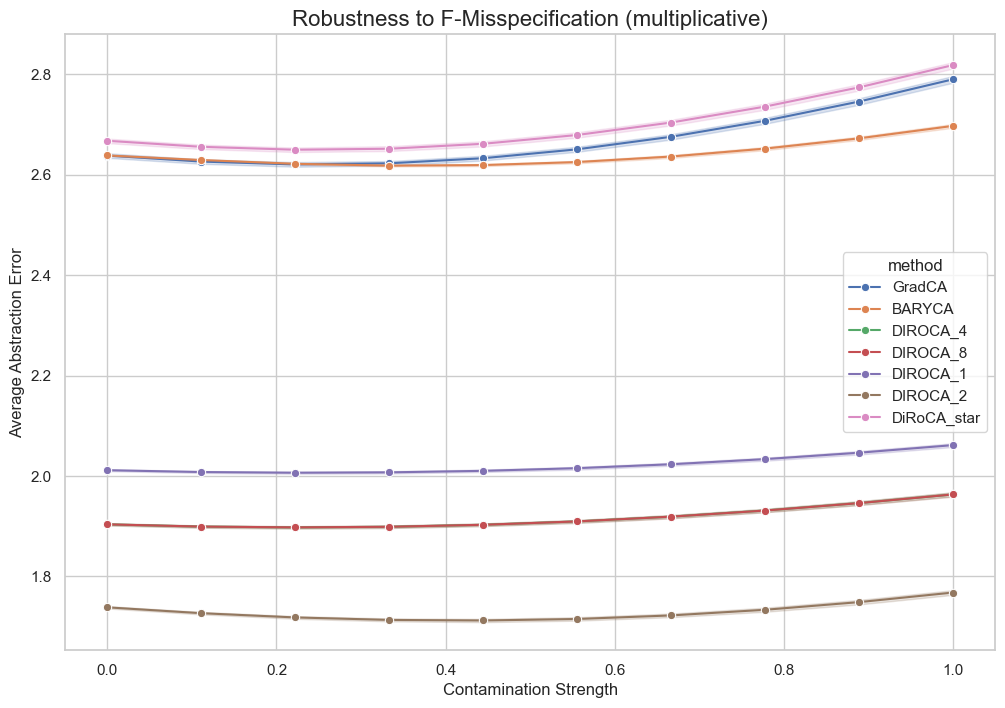


Overall Performance (Averaged Across All 'multiplicative' Strengths)
Method/Run                          | Mean Error ± 95% CI
DIROCA_2                            | 1.7298 ± 0.0212
DIROCA_4                            | 1.9172 ± 0.0242
DIROCA_8                            | 1.9172 ± 0.0242
DIROCA_1                            | 2.0224 ± 0.0206
BARYCA                              | 2.6408 ± 0.0262
GradCA                              | 2.6707 ± 0.0589
DiRoCA_star                         | 2.6995 ± 0.0586


In [80]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=f_spec_df, x='contamination', y='error', hue='method', marker='o', errorbar=('ci', 95))
plt.title(f'Robustness to F-Misspecification ({contamination_type_to_run})', fontsize=16)
plt.xlabel('Contamination Strength', fontsize=12)
plt.ylabel('Average Abstraction Error', fontsize=12)
plt.show()

print("\n" + "="*65)
print(f"Overall Performance (Averaged Across All '{contamination_type_to_run}' Strengths)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean Error ± 95% CI'}")
print("="*65)

summary = f_spec_df.groupby('method')['error'].agg(['mean', 'std', 'count'])
summary['sem'] = summary['std'] #/ np.sqrt(summary['count'])
# summary['ci95'] = 1.96 * summary['sem']
summary['ci95'] = summary['sem']

for method_name, row in summary.sort_values('mean').iterrows():
    print(f"{method_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")
print("="*65)

## ω contamination

In [81]:
def contaminate_omega_map(original_omega, num_misalignments):
    
    """Randomly re-wires a subset of entries in the omega map."""
    
    omega_keys = [k for k in original_omega.keys() if k is not None]
    omega_vals = [original_omega[k] for k in omega_keys if original_omega[k] is not None]

    contaminated_omega = original_omega.copy()
    
    # Bound the number of misalignments by the number of eligible keys.
    num_to_corrupt = min(num_misalignments, len(omega_keys))
    # Randomly select keys to corrupt.
    to_corrupt = random.sample(omega_keys, k=num_to_corrupt)
    
    # Create a random permutation of available targets (ensuring change)
    # Use the set of targets from eligible keys.
    all_targets = list(set(omega_vals))

    for key in to_corrupt:
        original_target = original_omega[key]
        # Only corrupt if there's an alternative available.
        available_targets = [t for t in all_targets if t != original_target]
        if available_targets:
            new_target = random.choice(available_targets)
            contaminated_omega[key] = new_target
            
    return contaminated_omega

In [ ]:
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ======================================================================
# 1. CONTROL PANEL
# ======================================================================

# Test from 0 misalignments up to all but one
max_misalignments = len(I_ll_relevant) # Leave at least one correct mapping
print(max_misalignments)
misalignment_levels = range(0, max_misalignments)
#misalignment_levels = np.linspace(0, max_misalignments, 11, dtype=int)

# Number of random contaminations to average over for each setting
num_trials = 20

# ======================================================================
# 2. EVALUATION LOOP
# ======================================================================
omega_spec_records = []
print("Omega-misspecification evaluation")

for num_misalignments in tqdm(misalignment_levels, desc="Misalignment Level"):
    for trial in range(num_trials):
        # Create a new scrambled omega map for each trial
        omega_cont = contaminate_omega_map(omega, num_misalignments)
        
        for i, fold_info in enumerate(saved_folds):
            for method_name, results_dict in results_to_evaluate.items():
                fold_results = results_dict.get(f'fold_{i}', {})
                for run_key, run_data in fold_results.items():

                    # --- Create a single, clean label for the method/run combination ---
                    if 'DIROCA' in method_name:
                        method_label = method_name
                    else:
                        method_label = method_name
                    # --- END OF CHANGE ---

                    T_learned = run_data['T_matrix']
                    test_indices = run_data['test_indices']
                    
                    errors_per_intervention = []
                    for iota in I_ll_relevant:
                        Dll_test = Dll_samples[iota][test_indices]
                        # Use the contaminated omega map
                        Dhl_test = Dhl_samples[omega_cont[iota]][test_indices]
                        
                        error = calculate_abstraction_error(T_learned, Dll_test, Dhl_test)
                        if not np.isnan(error): errors_per_intervention.append(error)
                    
                    avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                    
                    # Store a detailed record using the new method_label
                    record = {
                        'method': method_label, # <-- Use the new clean label
                        'misalignments': num_misalignments,
                        'trial': trial,
                        'fold': i,
                        'error': avg_error
                    }
                    omega_spec_records.append(record)

omega_spec_df = pd.DataFrame(omega_spec_records)
print("\n\n--- Omega-Misspecification Evaluation Complete ---")


6
Omega-misspecification evaluation


Misalignment Level: 100%|██████████| 6/6 [00:14<00:00,  2.49s/it]



--- Omega-Misspecification Evaluation Complete ---


In [83]:
# b. Print the Final Summary Table (now grouped only by method)
print("\n" + "="*65)
print("Overall Performance (Averaged Across All Misalignment Levels)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean Error ± 95% CI'}")
print("="*65)

summary = omega_spec_df.groupby('method')['error'].agg(['mean', 'std', 'count'])
summary['sem'] = summary['std'] #/ np.sqrt(summary['count'])
# summary['ci95'] = 1.96 * summary['sem']
summary['ci95'] = summary['sem']


for method_name, row in summary.sort_values('mean').iterrows():
    print(f"{method_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")
print("="*65)


Overall Performance (Averaged Across All Misalignment Levels)
Method/Run                          | Mean Error ± 95% CI
DIROCA_2                            | 1.6309 ± 0.0901
DIROCA_4                            | 1.7104 ± 0.1520
DIROCA_8                            | 1.7104 ± 0.1520
DIROCA_1                            | 1.7926 ± 0.1652
GradCA                              | 2.4419 ± 0.1434
DiRoCA_star                         | 2.4727 ± 0.1426
BARYCA                              | 2.5354 ± 0.1228


In [67]:
# b. Print the Final Summary Table (now grouped only by method)
print("\n" + "="*65)
print("Overall Performance (Averaged Across All Misalignment Levels)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean Error ± 95% CI'}")
print("="*65)

summary = omega_spec_df.groupby('method')['error'].agg(['mean', 'std', 'count'])
summary['sem'] = summary['std'] / np.sqrt(summary['count'])
# summary['ci95'] = 1.96 * summary['sem']
summary['ci95'] = summary['sem']


for method_name, row in summary.sort_values('mean').iterrows():
    print(f"{method_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")
print("="*65)


Overall Performance (Averaged Across All Misalignment Levels)
Method/Run                          | Mean Error ± 95% CI
DiRoCA_star                         | 7.3566 ± 0.0027
BARYCA                              | 7.3662 ± 0.0032
DIROCA_2                            | 7.6557 ± 0.0013
GradCA                              | 7.7490 ± 0.0025
DIROCA_1                            | 7.7679 ± 0.0015
DIROCA_4                            | 8.1537 ± 0.0018
DIROCA_8                            | 8.7082 ± 0.0024


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


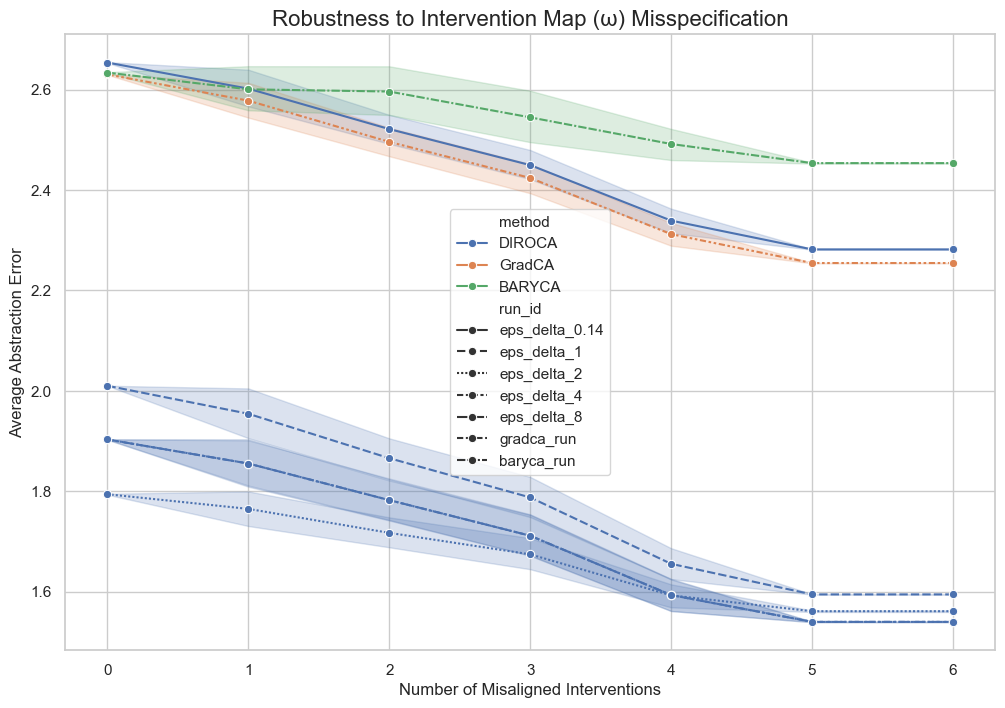


Overall Performance (Averaged Across All Misalignment Levels)
Method/Run                          | Mean Error ± Std Dev

--- Overall Omega-Misspecification Performance ---
BARYCA (baryca_run)                 | 2.5498 ± 0.0163
DIROCA (eps_delta_0.14)             | 2.4645 ± 0.0213
DIROCA (eps_delta_1)                | 1.7993 ± 0.0249
DIROCA (eps_delta_2)                | 1.6767 ± 0.0151
DIROCA (eps_delta_4)                | 1.7202 ± 0.0227
DIROCA (eps_delta_8)                | 1.7202 ± 0.0227
GradCA (gradca_run)                 | 2.4389 ± 0.0215


In [18]:
max_misalignments   = len(I_ll_relevant)
misalignment_levels = np.linspace(0, max_misalignments, 10, dtype=int)

num_trials           = 10

omega_spec_records = []
for num_misalignments in tqdm(misalignment_levels):
    for trial in range(num_trials):
        # Create a new scrambled omega map for each trial
        omega_cont = contaminate_omega_map(omega, num_misalignments)
        
        for i, fold_info in enumerate(saved_folds):
            for method_name, results_dict in results_to_evaluate.items():
                fold_results = results_dict[f'fold_{i}']
                for run_key, run_data in fold_results.items():
                    T_learned, test_indices = run_data['T_matrix'], run_data['test_indices']
                    
                    errors_per_intervention = []
                    for iota in I_ll_relevant:
                        Dll_test = Dll_samples[iota][test_indices]
                        # Use the contaminated omega map
                        Dhl_test = Dhl_samples[omega_cont[iota]][test_indices]
                        
                        error = calculate_abstraction_error(T_learned, Dll_test, Dhl_test)
                        if not np.isnan(error): errors_per_intervention.append(error)
                    
                    avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                    omega_spec_records.append({'method': method_name, 'run_id': run_key, 'misalignments': num_misalignments, 'error': avg_error})

omega_spec_df = pd.DataFrame(omega_spec_records)
# Calculate final summary table, averaging across all misalignment levels
omega_final_summary = omega_spec_df.groupby(['method', 'run_id'])['error'].agg(['mean', 'std', 'count'])
omega_final_summary['sem'] = omega_final_summary['std'] / np.sqrt(omega_final_summary['count'])
omega_final_summary['ci95'] = 1.96 * omega_final_summary['sem']

plt.figure(figsize=(12, 8))
sns.lineplot(data=omega_spec_df, x='misalignments', y='error', hue='method', style='run_id', marker='o', errorbar=('ci', 95))
plt.title('Robustness to Intervention Map (ω) Misspecification', fontsize=16)
plt.xlabel('Number of Misaligned Interventions', fontsize=12)
plt.ylabel('Average Abstraction Error', fontsize=12)
plt.show()

print("\n" + "="*65)
print("Overall Performance (Averaged Across All Misalignment Levels)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean Error ± Std Dev'}")
print("="*65)

# Print the final formatted table
print("\n--- Overall Omega-Misspecification Performance ---")
for index, row in omega_final_summary.iterrows():
    display_name = f"{row.name[0]} ({row.name[1]})"
    print(f"{display_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")